In [1]:
import numpy as np 
import pandas as pd 

import os


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
# # corr = df_train_1.corr()
# top_corr_features = corr.index
# sns.set(font_scale=3)


# plt.figure(figsize=(20,20))
# cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# g=sns.heatmap(df_train_1[top_corr_features].corr(),annot=True,cmap="GnBu")
# # ,annot_kws ={"size": 20}
# plt.show()



In [4]:
FX_TXN = pd.read_csv('../input/tbnesu/TBN_FX_TXN.csv')
TBN_RECENT_DT = pd.read_csv('../input/tbnesu/TBN_RECENT_DT.csv')
TBN_CIF = pd.read_csv('../input/tbnesu/TBN_CIF.csv')
TBN_CUST_BEHAVIOR= pd.read_csv('../input/tbnesu/TBN_CUST_BEHAVIOR.csv')

sub = pd.read_csv('../input/tbnesu/result_fx.csv')





In [5]:
TBN_CUST_BEHAVIOR

,CUST_NO,VISITDATE,PAGE
0,36915,9462,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/
1,36915,9528,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...
2,386570,9458,https://www.esunbank.com.tw/edrn/deoxt/rgws-cg...
3,14714,9457,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
4,14714,9485,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
...,...,...,...
2209859,139927,9567,https://www.esunbank.com.tw/edrn/pgusordq/cugf...
2209860,139927,9567,https://www.esunbank.com.tw/edrn/pgusordq/cugf...
2209861,139927,9567,https://www.esunbank.com.tw/edrn/pgusordq/cugf...
2209862,139927,9567,https://www.esunbank.com.tw/edrn/pgusordq/cugf...


In [6]:
import re
def parse_page_1(content):
    return re.search(r'(?<=tw/)\w+', content).group()
TBN_CUST_BEHAVIOR['PAGE_1'] = TBN_CUST_BEHAVIOR['PAGE'].apply(lambda x: parse_page_1(x))

In [7]:
import re
def parse_page_2(content):
    return content.split('/')[4]
TBN_CUST_BEHAVIOR['PAGE_2'] = TBN_CUST_BEHAVIOR['PAGE'].apply(lambda x: parse_page_2(x))

In [8]:
# from collections import Counter

# Counter(TBN_CUST_BEHAVIOR.loc[TBN_CUST_BEHAVIOR['CUST_NO'].isin(has_buy_cust)]['PAGE'])

In [9]:
def change_gender(gender):
    if gender == 'M':
        return 1
    elif gender == 'F':
        return 2
    else:
        return 0
TBN_CIF['GENDER_CODE'] = TBN_CIF['GENDER_CODE'].apply(lambda x: change_gender(x))

In [10]:
len(set(FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9478, 9507))['CUST_NO']) - set(TBN_CIF['CUST_NO']) )

12535

In [11]:
date_30_1 = FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9478, 9507))
date_30_1_cust_no = set(date_30_1['CUST_NO'])

date_60_1 = FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9508, 9537))
date_60_1_cust_no = set(date_60_1['CUST_NO'])

date_90_1 = FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9538, 9567))
date_90_1_cust_no = set(date_90_1['CUST_NO'])



In [12]:
def chagne_one_hot(train, c):
    onehotencoder = OneHotEncoder(sparse=False, categories='auto').fit(train[c].values.reshape(-1, 1).astype('str'))
    train_trans = onehotencoder.transform(train[c].values.reshape(-1, 1).astype('str'))
    for i in range(train_trans.shape[1]):
        train['{}_{}'.format(c, i)] = train_trans[:, i]
    train = train.drop(columns=c)

    return train

In [13]:
import copy
df_train_1 = copy.copy(TBN_CIF)
df_train_1['FX_IND'] = 0
df_train_1.loc[list(df_train_1.loc[df_train_1['CUST_NO'].isin(date_30_1_cust_no)].index), 'FX_IND'] = 1

df_train_2 = copy.copy(TBN_CIF)
df_train_2['FX_IND'] = 0
df_train_2.loc[list(df_train_2.loc[df_train_2['CUST_NO'].isin(date_60_1_cust_no)].index), 'FX_IND'] = 1

df_train_3 = copy.copy(TBN_CIF)
df_train_3['FX_IND'] = 0
df_train_3.loc[list(df_train_3.loc[df_train_3['CUST_NO'].isin(date_90_1_cust_no)].index), 'FX_IND'] = 1



In [14]:
len(date_30_1_cust_no), len(date_60_1_cust_no), len(date_90_1_cust_no)

(24881, 31486, 21509)

In [15]:
df_train_3.loc[df_train_3['FX_IND']==1].shape

(14162, 9)

In [16]:
TBN_CUST_BEHAVIOR = chagne_one_hot(TBN_CUST_BEHAVIOR, 'PAGE_1')
TBN_CUST_BEHAVIOR = chagne_one_hot(TBN_CUST_BEHAVIOR, 'PAGE_2')

In [17]:
lag_30_feature_txn = FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9448, 9477))
lag_30_feature_TBN_CUST_BEHAVIOR = TBN_CUST_BEHAVIOR.query('VISITDATE >= {} & VISITDATE <= {}'.format(9448, 9477))

lag_60_feature_txn = FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9478, 9507))
lag_60_feature_TBN_CUST_BEHAVIOR = TBN_CUST_BEHAVIOR.query('VISITDATE >= {} & VISITDATE <= {}'.format(9478, 9507))

lag_90_feature_txn = FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9508, 9537))
lag_90_feature_TBN_CUST_BEHAVIOR = TBN_CUST_BEHAVIOR.query('VISITDATE >= {} & VISITDATE <= {}'.format(9508, 9537))

lag_120_feature_txn = FX_TXN.query('TXN_DT >= {} & TXN_DT <= {}'.format(9538, 9567))
lag_120_feature_TBN_CUST_BEHAVIOR = TBN_CUST_BEHAVIOR.query('VISITDATE >= {} & VISITDATE <= {}'.format(9538, 9567))


In [18]:
df_train_1.head(10)

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,FX_IND
0,0,1,NaN,2.0,NaN,0,NaN,NaN,0
1,2,3,0.0,9393.0,NaN,0,1.0,NaN,0
2,5,4,0.0,2912.0,3.0,1,2.0,2.0,0
3,7,4,0.0,8332.0,5.0,1,2.0,1.0,0
4,8,4,0.0,744.0,3.0,1,2.0,1.0,0
5,10,4,0.0,4677.0,2.0,1,2.0,1.0,1
6,11,4,0.0,7936.0,6.0,1,1.0,1.0,0
7,13,4,0.0,3502.0,3.0,1,1.0,2.0,0
8,19,4,0.0,5418.0,3.0,1,2.0,1.0,0
9,21,4,0.0,4674.0,4.0,1,2.0,1.0,0


In [19]:
lag_30_feature_txn['number_of_transaction'] = lag_30_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('count')
lag_30_feature_txn['last_transaction_day'] = lag_30_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('max')

lag_60_feature_txn['number_of_transaction'] = lag_60_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('count')
lag_60_feature_txn['last_transaction_day'] = lag_60_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('max')

lag_90_feature_txn['number_of_transaction'] = lag_90_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('count')
lag_90_feature_txn['last_transaction_day'] = lag_90_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('max')

lag_120_feature_txn['number_of_transaction'] = lag_120_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('count')
lag_120_feature_txn['last_transaction_day'] = lag_120_feature_txn.groupby('CUST_NO')['TXN_DT'].transform('max')



# lag_30_feature_TBN_CUST_BEHAVIOR = chagne_one_hot(lag_30_feature_TBN_CUST_BEHAVIOR, 'PAGE_1')
# lag_30_feature_TBN_CUST_BEHAVIOR = chagne_one_hot(lag_30_feature_TBN_CUST_BEHAVIOR, 'PAGE_2')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [20]:
for i in range(6):
    print(i)
    col = 'PAGE_1_' + str(i)
    print(col)
    lag_30_feature_TBN_CUST_BEHAVIOR[col] = lag_30_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')
    lag_60_feature_TBN_CUST_BEHAVIOR[col] = lag_60_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')
    lag_90_feature_TBN_CUST_BEHAVIOR[col] = lag_90_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')
    lag_120_feature_TBN_CUST_BEHAVIOR[col] = lag_120_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
PAGE_1_0
1
PAGE_1_1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

2
PAGE_1_2
3
PAGE_1_3
4
PAGE_1_4
5
PAGE_1_5


In [21]:
for i in range(46):
    print(i)
    col = 'PAGE_2_' + str(i)
    print(col)
    lag_30_feature_TBN_CUST_BEHAVIOR[col] = lag_30_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')
    lag_60_feature_TBN_CUST_BEHAVIOR[col] = lag_60_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')
    lag_90_feature_TBN_CUST_BEHAVIOR[col] = lag_90_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')
    lag_120_feature_TBN_CUST_BEHAVIOR[col] = lag_120_feature_TBN_CUST_BEHAVIOR.groupby(['CUST_NO'])[col].transform('sum')

0
PAGE_2_0
1
PAGE_2_1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2
PAGE_2_2
3
PAGE_2_3
4
PAGE_2_4
5
PAGE_2_5
6
PAGE_2_6
7
PAGE_2_7
8
PAGE_2_8
9
PAGE_2_9
10
PAGE_2_10
11
PAGE_2_11
12
PAGE_2_12
13
PAGE_2_13
14
PAGE_2_14
15
PAGE_2_15
16
PAGE_2_16
17
PAGE_2_17
18
PAGE_2_18
19
PAGE_2_19
20
PAGE_2_20
21
PAGE_2_21
22
PAGE_2_22
23
PAGE_2_23
24
PAGE_2_24
25
PAGE_2_25
26
PAGE_2_26
27
PAGE_2_27
28
PAGE_2_28
29
PAGE_2_29
30
PAGE_2_30
31
PAGE_2_31
32
PAGE_2_32
33
PAGE_2_33
34
PAGE_2_34
35
PAGE_2_35
36
PAGE_2_36
37
PAGE_2_37
38
PAGE_2_38
39
PAGE_2_39
40
PAGE_2_40
41
PAGE_2_41
42
PAGE_2_42
43
PAGE_2_43
44
PAGE_2_44
45
PAGE_2_45


In [22]:
for stat in ['sum', 'mean', 'max', 'std', 'min']:
    new_col_name = 'FX_TXN_AMT_{}'.format(stat)
    temp_df = lag_30_feature_txn[['CUST_NO', 'FX_TXN_AMT']]
    temp_df = lag_30_feature_txn.groupby(['CUST_NO'])['FX_TXN_AMT'].agg([stat]).reset_index().rename(columns={stat: new_col_name})
    temp_df.index = list(temp_df['CUST_NO'])
    temp_df = temp_df[new_col_name].to_dict()  
    
    df_train_1[new_col_name] = df_train_1['CUST_NO'].map(temp_df).astype('float32')

In [23]:
for stat in ['sum', 'mean', 'max', 'std', 'min']:
    new_col_name = 'FX_TXN_AMT_{}'.format(stat)
    temp_df = lag_60_feature_txn[['CUST_NO', 'FX_TXN_AMT']]
    temp_df = lag_60_feature_txn.groupby(['CUST_NO'])['FX_TXN_AMT'].agg([stat]).reset_index().rename(columns={stat: new_col_name})
    temp_df.index = list(temp_df['CUST_NO'])
    temp_df = temp_df[new_col_name].to_dict()  
    
    df_train_2[new_col_name] = df_train_2['CUST_NO'].map(temp_df).astype('float32')

In [24]:
for stat in ['sum', 'mean', 'max', 'std', 'min']:
    new_col_name = 'FX_TXN_AMT_{}'.format(stat)
    temp_df = lag_90_feature_txn[['CUST_NO', 'FX_TXN_AMT']]
    temp_df = lag_90_feature_txn.groupby(['CUST_NO'])['FX_TXN_AMT'].agg([stat]).reset_index().rename(columns={stat: new_col_name})
    temp_df.index = list(temp_df['CUST_NO'])
    temp_df = temp_df[new_col_name].to_dict()  
    
    df_train_3[new_col_name] = df_train_3['CUST_NO'].map(temp_df).astype('float32')

In [25]:
df_test = copy.copy(TBN_CIF)
for stat in ['sum', 'mean', 'max', 'std', 'min']:
    new_col_name = 'FX_TXN_AMT_{}'.format(stat)
    temp_df = lag_120_feature_txn[['CUST_NO', 'FX_TXN_AMT']]
    temp_df = lag_120_feature_txn.groupby(['CUST_NO'])['FX_TXN_AMT'].agg([stat]).reset_index().rename(columns={stat: new_col_name})
    temp_df.index = list(temp_df['CUST_NO'])
    temp_df = temp_df[new_col_name].to_dict()  
    
    df_test[new_col_name] = df_test['CUST_NO'].map(temp_df).astype('float32')

In [26]:
lag_30_feature_TBN_CUST_BEHAVIOR = lag_30_feature_TBN_CUST_BEHAVIOR.drop_duplicates('CUST_NO')
lag_60_feature_TBN_CUST_BEHAVIOR = lag_60_feature_TBN_CUST_BEHAVIOR.drop_duplicates('CUST_NO')
lag_90_feature_TBN_CUST_BEHAVIOR = lag_90_feature_TBN_CUST_BEHAVIOR.drop_duplicates('CUST_NO')
lag_120_feature_TBN_CUST_BEHAVIOR = lag_120_feature_TBN_CUST_BEHAVIOR.drop_duplicates('CUST_NO')


In [27]:
lag_30_feature_txn = lag_30_feature_txn.drop_duplicates('CUST_NO')
lag_60_feature_txn = lag_60_feature_txn.drop_duplicates('CUST_NO')
lag_90_feature_txn = lag_90_feature_txn.drop_duplicates('CUST_NO')
lag_120_feature_txn = lag_90_feature_txn.drop_duplicates('CUST_NO')

In [28]:
df_train_1 = df_train_1.merge(lag_30_feature_TBN_CUST_BEHAVIOR, how='left', on='CUST_NO')
df_train_2 = df_train_2.merge(lag_60_feature_TBN_CUST_BEHAVIOR, how='left', on='CUST_NO')
df_train_3 = df_train_3.merge(lag_90_feature_TBN_CUST_BEHAVIOR, how='left', on='CUST_NO')

df_train_1 = df_train_1.merge(lag_30_feature_txn, how='left', on='CUST_NO')
df_train_2 = df_train_2.merge(lag_60_feature_txn, how='left', on='CUST_NO')
df_train_3 = df_train_3.merge(lag_90_feature_txn, how='left', on='CUST_NO')

df_test = df_test.merge(lag_120_feature_TBN_CUST_BEHAVIOR, how='left', on='CUST_NO')
df_test = df_test.merge(lag_120_feature_txn, how='left', on='CUST_NO')


In [29]:
df_train_1.loc[df_train_1['FX_IND'] == 1].shape, df_train_2.loc[df_train_2['FX_IND'] == 1].shape, df_train_3.loc[df_train_3['FX_IND'] == 1].shape

((12346, 77), (16800, 77), (14162, 77))

In [30]:
# df_train = pd.concat([df_train_1, df_train_2, df_train_3]).reset_index(drop=True)

In [31]:
#test = copy.copy(df_train_3)
# df_train = copy.copy(df_train_2)

# df_train = df_train.fillna(0)
# df_train['has_buy_past30'] = df_train['FX_TXN_AMT_mean'].apply(lambda x : 1 if x != 0 else 0)

In [32]:
df_train_1 = df_train_1.fillna(0)
df_train_1['has_buy_past30'] = df_train_1['FX_TXN_AMT_mean'].apply(lambda x : 1 if x != 0 else 0)

df_train_2 = df_train_2.fillna(0)
df_train_2['has_buy_past30'] = df_train_2['FX_TXN_AMT_mean'].apply(lambda x : 1 if x != 0 else 0)

df_train_3 = df_train_3.fillna(0)
df_train_3['has_buy_past30'] = df_train_3['FX_TXN_AMT_mean'].apply(lambda x : 1 if x != 0 else 0)

df_test = df_test.fillna(0)
df_test['has_buy_past30'] = df_test['FX_TXN_AMT_mean'].apply(lambda x : 1 if x != 0 else 0)

In [33]:
df_train = copy.copy(df_train_1)


In [34]:
import os
import gc
import time
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold, GroupKFold

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def threshold_search(y_true, y_proba):

    micro_best_threshold = 0
    micro_best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
 
        micro_score = f1_score(y_true, np.where(y_proba>=threshold , 1 ,0))
        if micro_score > micro_best_score:
            micro_best_threshold = threshold
            micro_best_score = micro_score
    search_result = {'f1_threshold': micro_best_threshold, 'f1': micro_best_score}
    return search_result


features_columns = list(df_train_1.columns)

not_use_feature_columns = ['CUST_NO', 'FX_IND', 'VISITDATE', 'PAGE', 'TXN_DT',
                           'FX_TXN_AMT',
                           ]

for i in not_use_feature_columns:
    features_columns.remove(i)
 
print(features_columns)

SEED = 777
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'FX_IND'


params = {
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':-1,
            'learning_rate':0.01,
            'num_leaves': 2**6,
            'max_depth':-1,
            'tree_learner':'serial',
            'colsample_bytree': 0.4,
            'subsample_freq':1,
            'subsample':0.8,
            'n_estimators': 5000,
            'max_bin':255,
            'verbose':-1,
            'seed': SEED,
            'early_stopping_rounds':200, 
        } 

print(f'The total of features : {len(features_columns)}')

NFOLDS = 5
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train_1[features_columns].columns

folds = KFold(n_splits=NFOLDS, random_state=SEED)
# folds = GroupKFold(n_splits=NFOLDS)

X,y = df_train_1[features_columns], df_train_1[TARGET]    
test_2 = df_train_2[features_columns] 
test_3 = df_train_3[features_columns] 

predictions_2 = np.zeros(len(test_2))
predictions_3 = np.zeros(len(test_3))
oof = np.zeros(len(df_train_1))
# del train, test
categorical_feature = ['AGE', 'CHILDREN_CNT', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'WORK_MTHS']
#split_groups = df_train['month']
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
    print('Fold:',fold_)
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]

    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  

    estimator = lgb.train(
        params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 200,
        categorical_feature = categorical_feature
    )   

    predictions_2 += estimator.predict(test_2) / NFOLDS
    predictions_3 += estimator.predict(test_3) / NFOLDS
    oof[val_idx] += estimator.predict(vl_x)
    
    feature_importances['fold_{}'.format(fold_ + 1)] = estimator.feature_importance()
    del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data, estimator
    gc.collect()

print('OOF AUC:', roc_auc_score(y, oof))



# plot feature importances
# feature_importances.to_csv('feature_importances.csv')
# feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# # feature_importances.to_csv('feature_importances.csv')

# plt.figure(figsize=(16, 16))
# sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
# plt.title('100 TOP feature importance over folds average');

search_resutls = threshold_search(y.values, oof)
search_resutls

['AGE', 'CHILDREN_CNT', 'CUST_START_DT', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'WORK_MTHS', 'FX_TXN_AMT_sum', 'FX_TXN_AMT_mean', 'FX_TXN_AMT_max', 'FX_TXN_AMT_std', 'FX_TXN_AMT_min', 'PAGE_1_0', 'PAGE_1_1', 'PAGE_1_2', 'PAGE_1_3', 'PAGE_1_4', 'PAGE_1_5', 'PAGE_2_0', 'PAGE_2_1', 'PAGE_2_2', 'PAGE_2_3', 'PAGE_2_4', 'PAGE_2_5', 'PAGE_2_6', 'PAGE_2_7', 'PAGE_2_8', 'PAGE_2_9', 'PAGE_2_10', 'PAGE_2_11', 'PAGE_2_12', 'PAGE_2_13', 'PAGE_2_14', 'PAGE_2_15', 'PAGE_2_16', 'PAGE_2_17', 'PAGE_2_18', 'PAGE_2_19', 'PAGE_2_20', 'PAGE_2_21', 'PAGE_2_22', 'PAGE_2_23', 'PAGE_2_24', 'PAGE_2_25', 'PAGE_2_26', 'PAGE_2_27', 'PAGE_2_28', 'PAGE_2_29', 'PAGE_2_30', 'PAGE_2_31', 'PAGE_2_32', 'PAGE_2_33', 'PAGE_2_34', 'PAGE_2_35', 'PAGE_2_36', 'PAGE_2_37', 'PAGE_2_38', 'PAGE_2_39', 'PAGE_2_40', 'PAGE_2_41', 'PAGE_2_42', 'PAGE_2_43', 'PAGE_2_44', 'PAGE_2_45', 'PAGE_2_46', 'PAGE_2_47', 'PAGE_2_48', 'PAGE_2_49', 'PAGE_2_50', 'number_of_transaction', 'last_transaction_day', 'has_buy_past30']
The total of fe

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'CHILDREN_CNT', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'WORK_MTHS']
  'New categorical_featur

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.848638	valid_1's auc: 0.834835
[400]	training's auc: 0.854442	valid_1's auc: 0.835381
[600]	training's auc: 0.858659	valid_1's auc: 0.835832
[800]	training's auc: 0.862142	valid_1's auc: 0.835679
Early stopping, best iteration is:
[607]	training's auc: 0.858786	valid_1's auc: 0.835844
Fold: 1
150143 37536
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.84743	valid_1's auc: 0.841239
[400]	training's auc: 0.853709	valid_1's auc: 0.841231
Early stopping, best iteration is:
[260]	training's auc: 0.849745	valid_1's auc: 0.841451
Fold: 2
150143 37536
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.846767	valid_1's auc: 0.838476
[400]	training's auc: 0.853157	valid_1's auc: 0.83981
[600]	training's auc: 0.857094	valid_1's auc: 0.840149
[800]	training's auc: 0.860715	valid_1's auc: 0.840394
[1000]	training's auc: 0.86352	valid_1's auc

{'f1_threshold': 0.22, 'f1': 0.4424199195953832}

In [35]:
f1_score(df_train_2['FX_IND'], np.where(predictions_2>=search_resutls['f1_threshold'] , 1 ,0))

0.4640906608410705

In [36]:
f1_score(df_train_3['FX_IND'], np.where(predictions_3>=search_resutls['f1_threshold'] , 1 ,0))

0.4421242588295952

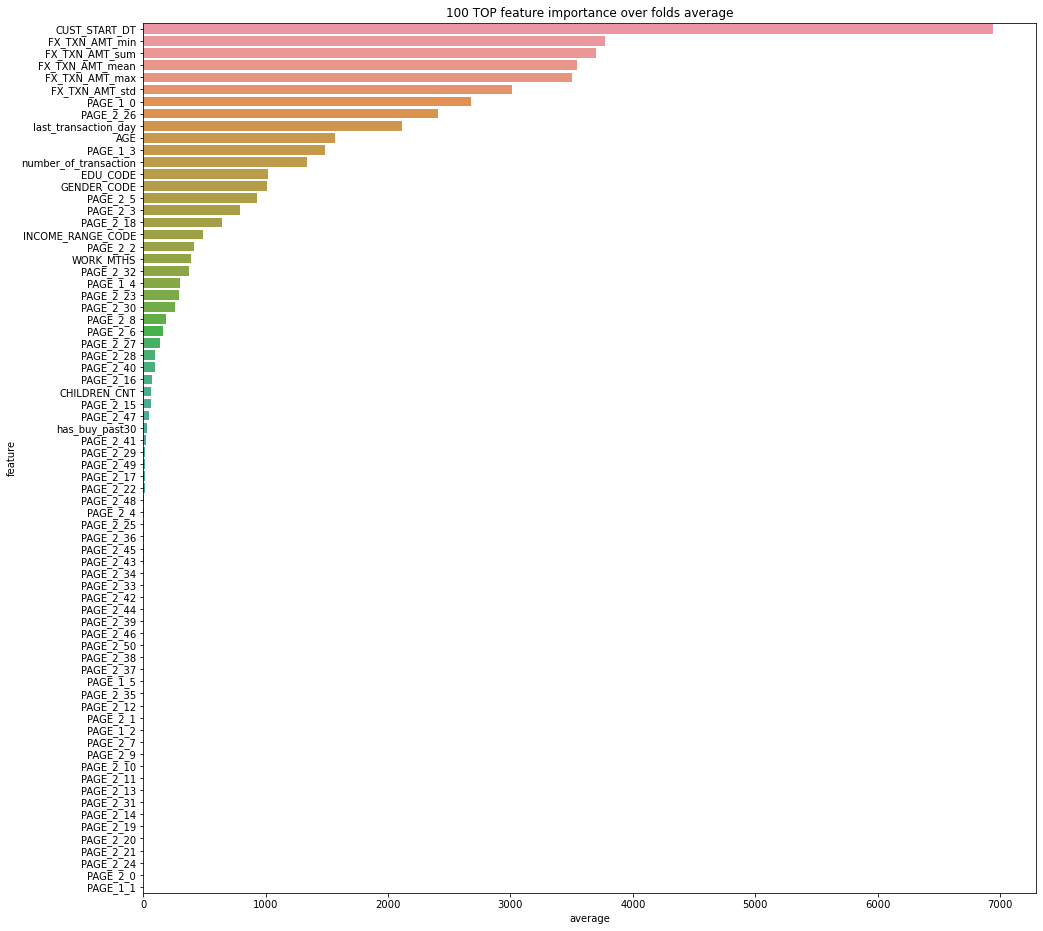

In [37]:
feature_importances.to_csv('feature_importances.csv')
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over folds average');

In [38]:
df_train_1['month'] = 1
df_train_2['month'] = 2
df_train_3['month'] = 3

In [39]:
df_train = pd.concat([df_train_1, df_train_2, df_train_3]).reset_index(drop=True)

In [40]:
import os
import gc
import time
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold, GroupKFold


def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def threshold_search(y_true, y_proba):

    micro_best_threshold = 0
    micro_best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
 
        micro_score = f1_score(y_true, np.where(y_proba>=threshold , 1 ,0))
        if micro_score > micro_best_score:
            micro_best_threshold = threshold
            micro_best_score = micro_score
    search_result = {'f1_threshold': micro_best_threshold, 'f1': micro_best_score}
    return search_result


features_columns = list(df_train.columns)

not_use_feature_columns = ['CUST_NO', 'FX_IND', 'VISITDATE', 'PAGE', 'TXN_DT',
                           'FX_TXN_AMT', 'month']

for i in not_use_feature_columns:
    print(i)
    features_columns.remove(i)
 


SEED = 777
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'FX_IND'


params = {
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':-1,
            'learning_rate':0.01,
            'num_leaves': 2**6,
            'max_depth':-1,
            'tree_learner':'serial',
            'colsample_bytree': 0.4,
            'subsample_freq':1,
            'subsample':0.8,
            'n_estimators': 5000,
            'max_bin':255,
            'verbose':-1,
            'seed': SEED,
            'early_stopping_rounds':200, 
        } 

print(f'The total of features : {len(features_columns)}')

NFOLDS = 3
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train[features_columns].columns

# folds = KFold(n_splits=NFOLDS, random_state=SEED)
folds = GroupKFold(n_splits=NFOLDS)

X,y = df_train[features_columns], df_train[TARGET]    
P = df_test[features_columns] 

predictions = np.zeros(len(df_test))
oof = np.zeros(len(df_train))
# del train, test
categorical_feature = ['AGE', 'CHILDREN_CNT', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'WORK_MTHS']

split_groups = df_train['month']
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
    print('Fold:',fold_)
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]

    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  

    estimator = lgb.train(
        params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 200,
        categorical_feature = categorical_feature
    )   

    predictions += estimator.predict(P) /NFOLDS

    oof[val_idx] += estimator.predict(vl_x)

    feature_importances['fold_{}'.format(fold_ + 1)] = estimator.feature_importance()
    del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
    gc.collect()

print('OOF AUC:', roc_auc_score(y, oof))



# plot feature importances
# feature_importances.to_csv('feature_importances.csv')
# feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# # feature_importances.to_csv('feature_importances.csv')

# plt.figure(figsize=(16, 16))
# sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
# plt.title('100 TOP feature importance over folds average');

search_resutls = threshold_search(y.values, oof)

CUST_NO
FX_IND
VISITDATE
PAGE
TXN_DT
FX_TXN_AMT
month
The total of features : 72
Fold: 0
375358 187679


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'CHILDREN_CNT', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'WORK_MTHS']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.812726	valid_1's auc: 0.780724
[400]	training's auc: 0.817003	valid_1's auc: 0.783623
[600]	training's auc: 0.819216	valid_1's auc: 0.784877
[800]	training's auc: 0.820849	valid_1's auc: 0.785538
[1000]	training's auc: 0.822285	valid_1's auc: 0.785849
[1200]	training's auc: 0.823538	valid_1's auc: 0.786072
[1400]	training's auc: 0.824617	valid_1's auc: 0.786181
[1600]	training's auc: 0.825619	valid_1's auc: 0.786269
[1800]	training's auc: 0.826574	valid_1's auc: 0.786291
[2000]	training's auc: 0.827436	valid_1's auc: 0.786324
[2200]	training's auc: 0.828363	valid_1's auc: 0.786366
[2400]	training's auc: 0.829181	valid_1's auc: 0.786394
[2600]	training's auc: 0.8299	valid_1's auc: 0.786443
[2800]	training's auc: 0.830602	valid_1's auc: 0.786453
[3000]	training's auc: 0.831322	valid_1's auc: 0.786438
Early stopping, best iteration is:
[2818]	training's auc: 0.830696	valid_1's auc: 0.786469
Fold: 1
37535

In [41]:
# {'f1_micro_threshold': 0.17, 'f1_micro': 0.43860296378281993} 0.826
# {'f1_micro_threshold': 0.17, 'f1_micro': 0.43910681955340974} 0.8262
# {'f1_micro_threshold': 0.18, 'f1_micro': 0.4401327546591779}

# search_resutls
search_resutls

{'f1_threshold': 0.23, 'f1': 0.4467288745243184}

In [42]:
df_train.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,FX_IND,FX_TXN_AMT_sum,...,PAGE_2_47,PAGE_2_48,PAGE_2_49,PAGE_2_50,TXN_DT,FX_TXN_AMT,number_of_transaction,last_transaction_day,has_buy_past30,month
0,0,1,0.0,2.0,0.0,0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,2,3,0.0,9393.0,0.0,0,1.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,5,4,0.0,2912.0,3.0,1,2.0,2.0,0,267630.0,...,0.0,0.0,0.0,0.0,9452.0,25981.0,8.0,9472.0,1,1
3,7,4,0.0,8332.0,5.0,1,2.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,8,4,0.0,744.0,3.0,1,2.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


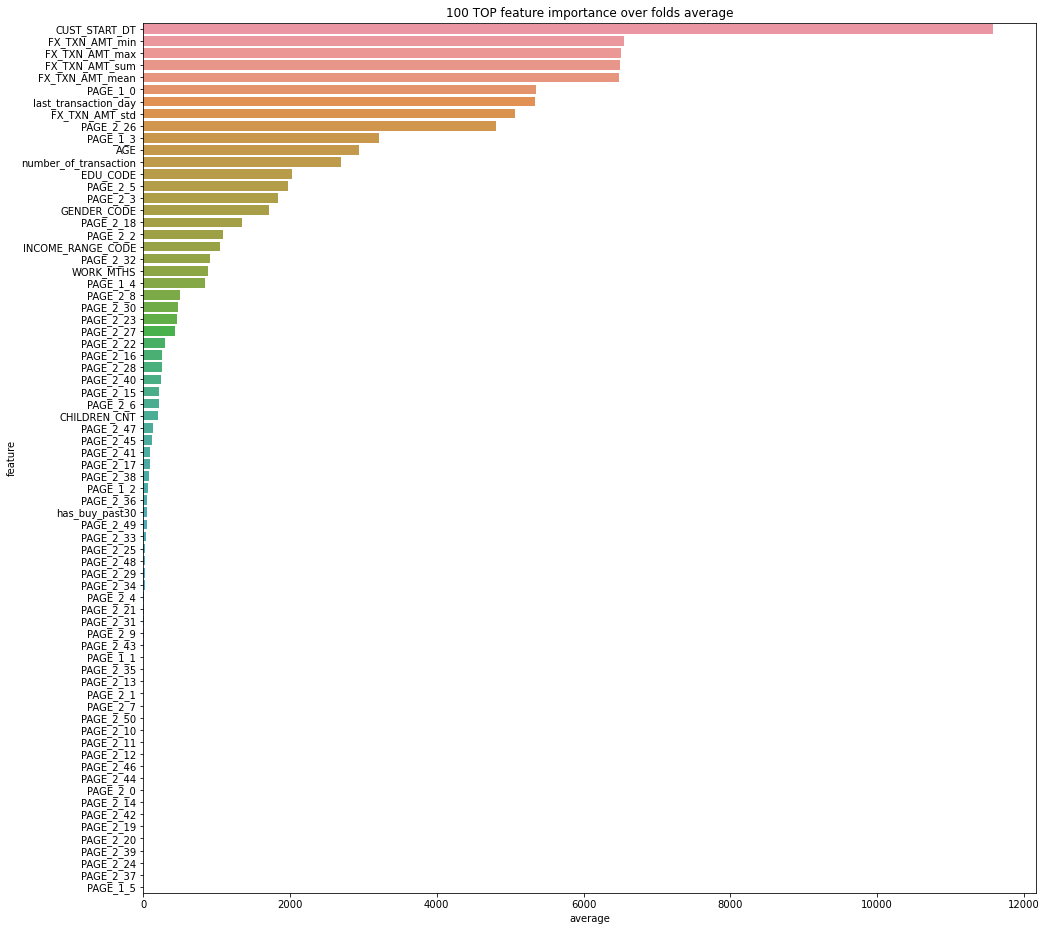

In [43]:
feature_importances.to_csv('feature_importances.csv')
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over folds average');

In [44]:
df_test['FX_IND'] = np.where(predictions>=search_resutls['f1_threshold'] , 1 ,0)

In [45]:
sub = sub.drop(columns=['FX_IND'])

In [46]:
sub = sub.merge(df_test.loc[:, ['CUST_NO', 'FX_IND']], on='CUST_NO')

In [47]:
sub

,CUST_NO,FX_IND
0,54986,1
1,177319,0
2,97048,1
3,415159,1
4,193332,0
...,...,...
29849,133655,0
29850,160156,0
29851,309709,0
29852,249814,1


In [48]:
df_test.loc[:, ['CUST_NO', 'FX_IND']].to_csv('./test.csv', index=False)

In [49]:
sub.to_csv('./submission.csv', index=False)